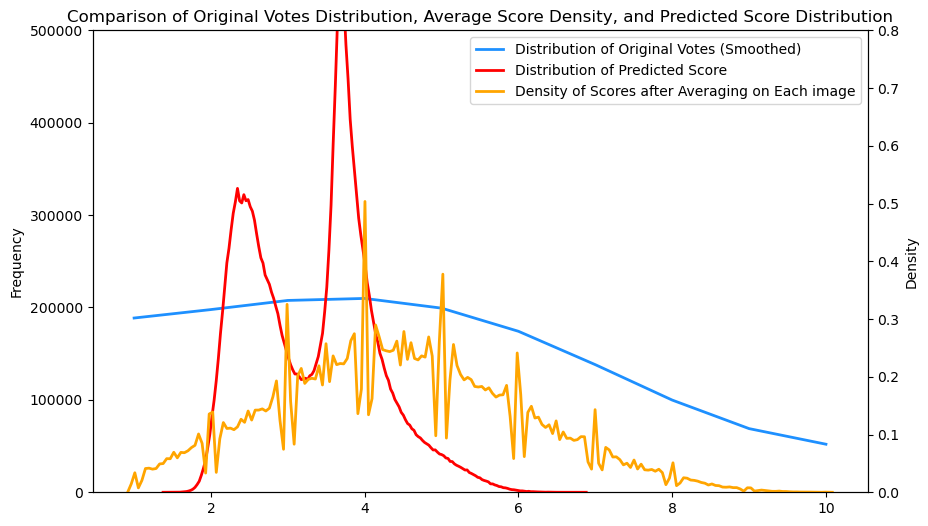

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.ndimage import gaussian_filter1d


file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# read data of votes 
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
vote_counts = df_votes['Votes'].value_counts().sort_index()  
average_data = df_votes['Average']  

# Gaussian smoothing of votes data
vote_counts_smoothed = gaussian_filter1d(vote_counts.values, sigma=1.5)

# read data of predicted_score 
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist()) 
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# Start drawing a chart
plt.figure(figsize=(10, 6))

# Primary axis: Plot the frequency distribution of Vote Counts
ax1 = plt.gca()
ax1.plot(vote_counts.index, vote_counts_smoothed, color="#1E90FF", label="Distribution of Original Votes (Smoothed)", linewidth=2)
ax1.set_ylabel('Frequency', color="black")  
ax1.tick_params(axis='y', labelcolor="black", color="black")  
ax1.set_ylim(0, 500000)  

# Secondary axis: Plot Predicted Score Density and Average Score Density
ax2 = ax1.twinx()
sns.kdeplot(scores_df['predicted_score'], color="red", label="Distribution of Predicted Score", ax=ax2, bw_adjust=0.1, linewidth=2)
sns.kdeplot(average_data, color="orange", label="Density of Scores after Averaging on Each image", ax=ax2, bw_adjust=0.3, linewidth=2)

# y
ax2.set_ylim(0, 0.8)  
ax2.set_ylabel('Density', color="black")  
ax2.tick_params(axis='y', labelcolor="black", color="black")  

# x
plt.xlabel('Score')
plt.title('Comparison of Original Votes Distribution, Average Score Density, and Predicted Score Distribution')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.show()


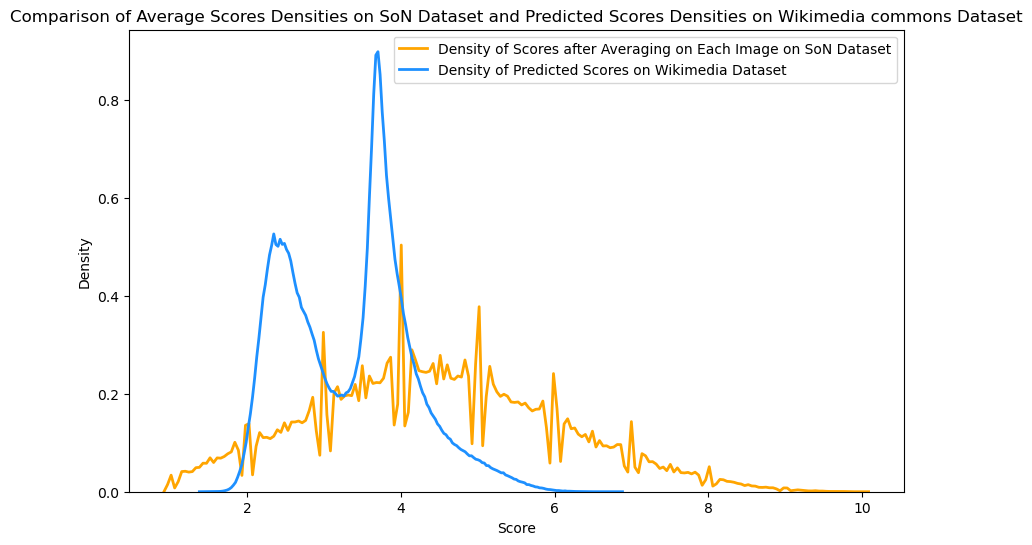

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

# File paths
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# Read and process vote data
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
average_data = df_votes['Average']

# Flatten votes into a single list for density calculation
votes_flattened = df_votes['Votes'].tolist()

# Read and process predicted score data
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist())
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# Start drawing the density chart
plt.figure(figsize=(10, 6))

# Plot density of original votes
#sns.kdeplot(votes_flattened, color="#1E90FF", label="Density of Original Votes", bw_adjust=0.5, linewidth=2)

# Plot density of average scores
sns.kdeplot(average_data, color="orange", label="Density of Scores after Averaging on Each Image on SoN Dataset", bw_adjust=0.3, linewidth=2)

# Plot density of predicted scores
sns.kdeplot(scores_df['predicted_score'], color="#1E90FF", label="Density of Predicted Scores on Wikimedia Dataset", bw_adjust=0.1, linewidth=2)

# Chart settings
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Comparison of Average Scores Densities on SoN Dataset and Predicted Scores Densities on Wikimedia commons Dataset')
plt.legend(loc='upper right')
plt.show()


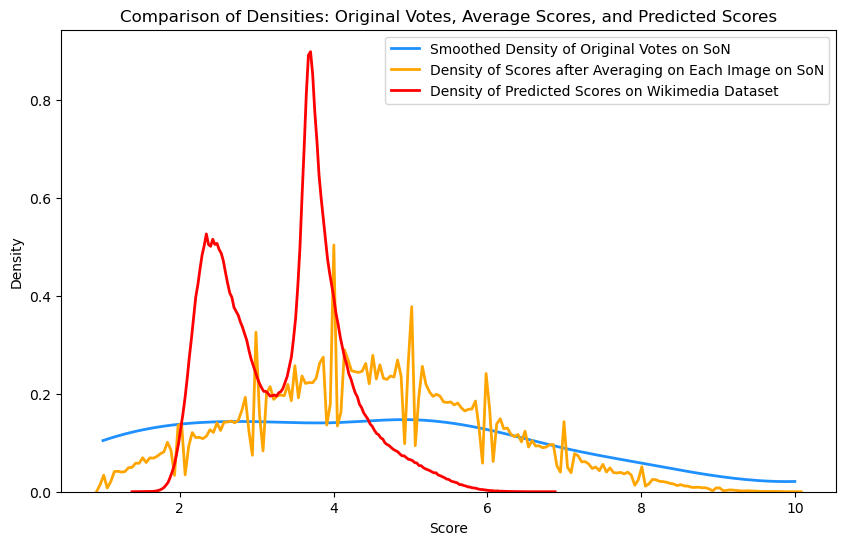

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from collections import Counter

# File paths
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# Read and process vote data
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
average_data = df_votes['Average']

# Flatten votes into a single list and count the frequency of each integer score
votes_flattened = df_votes['Votes'].tolist()
vote_counts = Counter(votes_flattened)

# Extract integer scores and their frequencies
scores = np.array(list(vote_counts.keys()))
frequencies = np.array(list(vote_counts.values()))
densities = frequencies / np.sum(frequencies)  # Normalize to get density

# Sort scores and densities to ensure a strictly increasing sequence
sorted_indices = np.argsort(scores)
scores = scores[sorted_indices]
densities = densities[sorted_indices]

# Use interpolation to create a smooth curve
x_new = np.linspace(min(scores), max(scores), 300)  # Generate more x values for a smooth curve
spl = make_interp_spline(scores, densities, k=3)  # k=3 for cubic spline interpolation
y_smooth = spl(x_new)

# Read and process predicted score data
scores_list = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores_list.extend(df['predicted_score'].dropna().tolist())
scores_df = pd.DataFrame(scores_list, columns=['predicted_score'])

# Start drawing the density chart
plt.figure(figsize=(10, 6))

# Plot the smoothed density of original votes as a curve
plt.plot(x_new, y_smooth, color="#1E90FF", label="Smoothed Density of Original Votes on SoN", linewidth=2)

# Plot density of average scores using KDE
sns.kdeplot(average_data, color="orange", label="Density of Scores after Averaging on Each Image on SoN", bw_adjust=0.3, linewidth=2)

# Plot density of predicted scores using KDE
sns.kdeplot(scores_df['predicted_score'], color="red", label="Density of Predicted Scores on Wikimedia Dataset", bw_adjust=0.1, linewidth=2)

# Chart settings
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Comparison of Densities: Original Votes, Average Scores, and Predicted Scores')
plt.legend(loc='upper right')
plt.show()
